In [141]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## Load Data

In [142]:
data = pd.read_csv("NSE-TATA.csv")

In [143]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858,2131.09


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2100 non-null   object 
 1   Open                  2100 non-null   float64
 2   High                  2100 non-null   float64
 3   Low                   2100 non-null   float64
 4   Last                  2100 non-null   float64
 5   Close                 2100 non-null   float64
 6   Total Trade Quantity  2100 non-null   int64  
 7   Turnover (Lacs)       2100 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 131.4+ KB


## Spliting Data as Train and Validation

In [145]:
length_data = len(data)     # rows that data has
split_ratio = 0.8          # %80 train + %20 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2100
Train data length : 1680
Validation data lenth : 420


In [146]:
data.index=data['Date']
data=data.sort_index(ascending=True,axis=0)

train_data=pd.DataFrame(index=range(0,length_train),columns=['Date','Close'])
for i in range(0,length_train):
    train_data["Date"][i]=data['Date'][i]
    train_data["Close"][i]=data["Close"][i]
    
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Close
0,2010-07-21,121.55
1,2010-07-22,120.9
2,2010-07-23,120.65
3,2010-07-26,117.6
4,2010-07-27,118.65
...,...,...
1675,2017-04-20,152.15
1676,2017-04-21,151.3
1677,2017-04-24,151.95
1678,2017-04-25,151.7


In [147]:
validation_data=pd.DataFrame(index=range(length_train,len(data)),columns=['Date','Close'])
for i in range(length_train,len(data)):
    validation_data["Date"][i]=data['Date'][i]
    validation_data["Close"][i]=data["Close"][i]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Close
1680,2017-04-27,152.1
1681,2017-04-28,153.1
1682,2017-05-02,157.7
1683,2017-05-03,156.2
1684,2017-05-04,155.35
...,...,...
2095,2018-12-31,219.4
2096,2019-01-01,219.1
2097,2019-01-02,214.6
2098,2019-01-03,210.05


## Creating Train Dataset from Train split

In [148]:
dataset_train = train_data.Close.values
dataset_train.shape

(1680,)

In [149]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1680, 1)

## Normalization / Feature Scaling

In [150]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1680, 1)

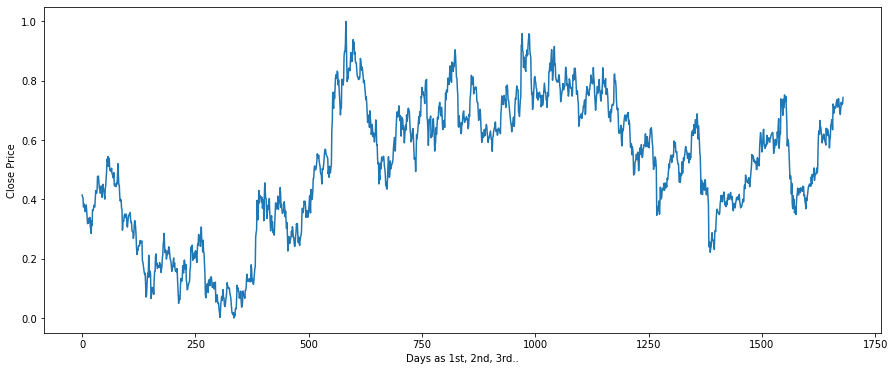

In [151]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Close Price")
plt.show()

## Creating X_train and y_train from Train data

In [152]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [153]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1630, 50)
Shape of y_train before reshape : (1630,)


In [154]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1630, 50, 1)
Shape of y_train after reshape : (1630, 1)


## Creating RNN model

In [155]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [156]:
# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


In [157]:
# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

In [158]:
# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

In [159]:
# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

In [160]:
# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)


Epoch 1/50
51/51 [==============================] - 14s 56ms/step - loss: 0.6444 - accuracy: 6.2298e-04
Epoch 2/50
51/51 [==============================] - 3s 51ms/step - loss: 0.3148 - accuracy: 0.0010
Epoch 3/50
51/51 [==============================] - 3s 59ms/step - loss: 0.2019 - accuracy: 0.0021
Epoch 4/50
51/51 [==============================] - 3s 60ms/step - loss: 0.1328 - accuracy: 6.0400e-05 1s - loss: 0.1349 -  - ETA: 0s - loss: 0.1338 - 
Epoch 5/50
51/51 [==============================] - 3s 59ms/step - loss: 0.1078 - accuracy: 8.1957e-04
Epoch 6/50
51/51 [==============================] - 3s 58ms/step - loss: 0.0859 - accuracy: 2.7616e-04
Epoch 7/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0733 - accuracy: 0.0020
Epoch 8/50
51/51 [==============================] - 3s 59ms/step - loss: 0.0559 - accuracy: 9.1041e-04 2s - l - ETA: 1s - loss: 0.0572 - accuracy:  - ETA: 0s - loss: 0
Epoch 9/50
51/51 [==============================] - 3s 58ms/step - loss: 

In [161]:
regressor.save("rnn_model.h5")

## Model predictions for train data

In [162]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

(1630, 1)

In [163]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1630, 1)

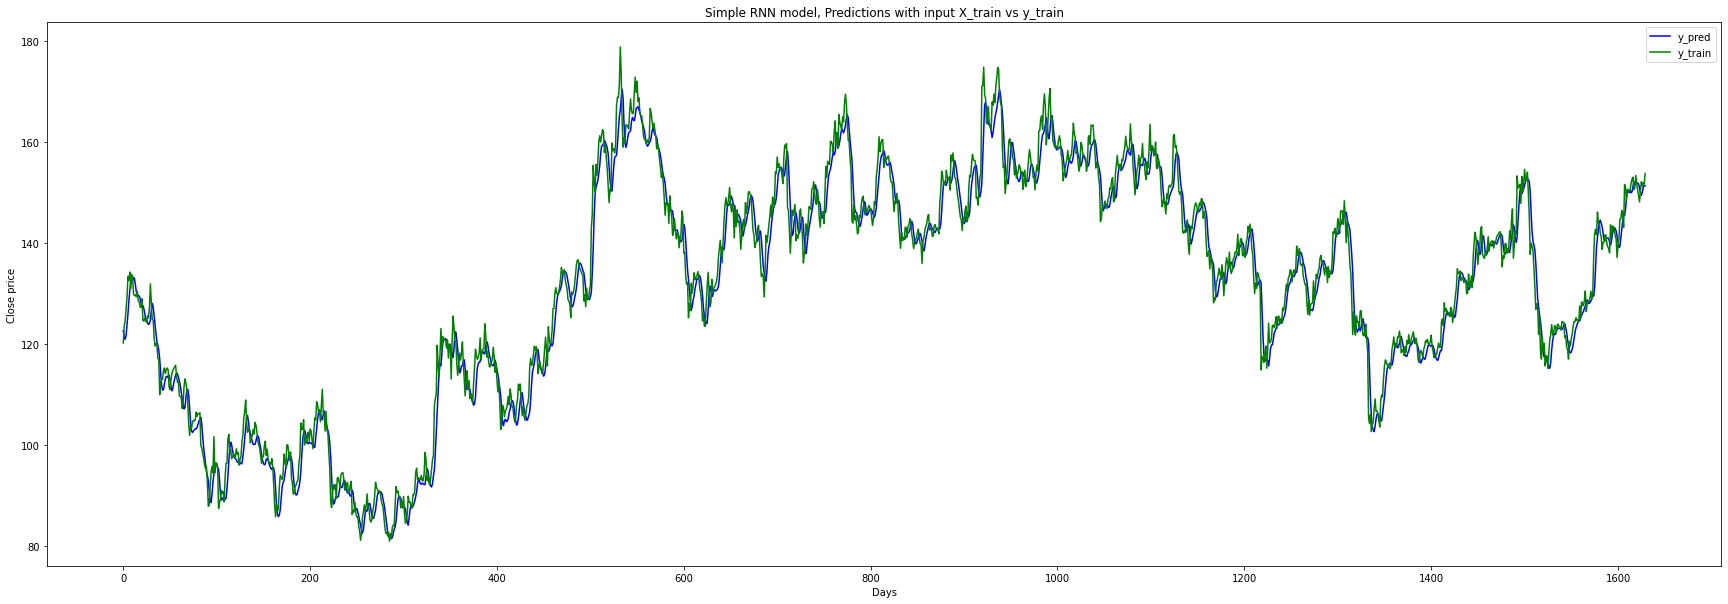

In [164]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

## Creating Test Dataset from Validation Data

### Converting array and scaling

In [165]:
dataset_validation = validation_data.Close.values  # getting "close" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (420, 1)


### Creating X_test and y_test

In [166]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [167]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [168]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (370, 50)
Shape of y_test before reshape : (370,)


### Reshape

In [169]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [170]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (370, 50, 1)
Shape of y_test after reshape : (370, 1)


## Evaluating with Validation Data

In [171]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

Shape of y_pred_of_test : (370, 1)


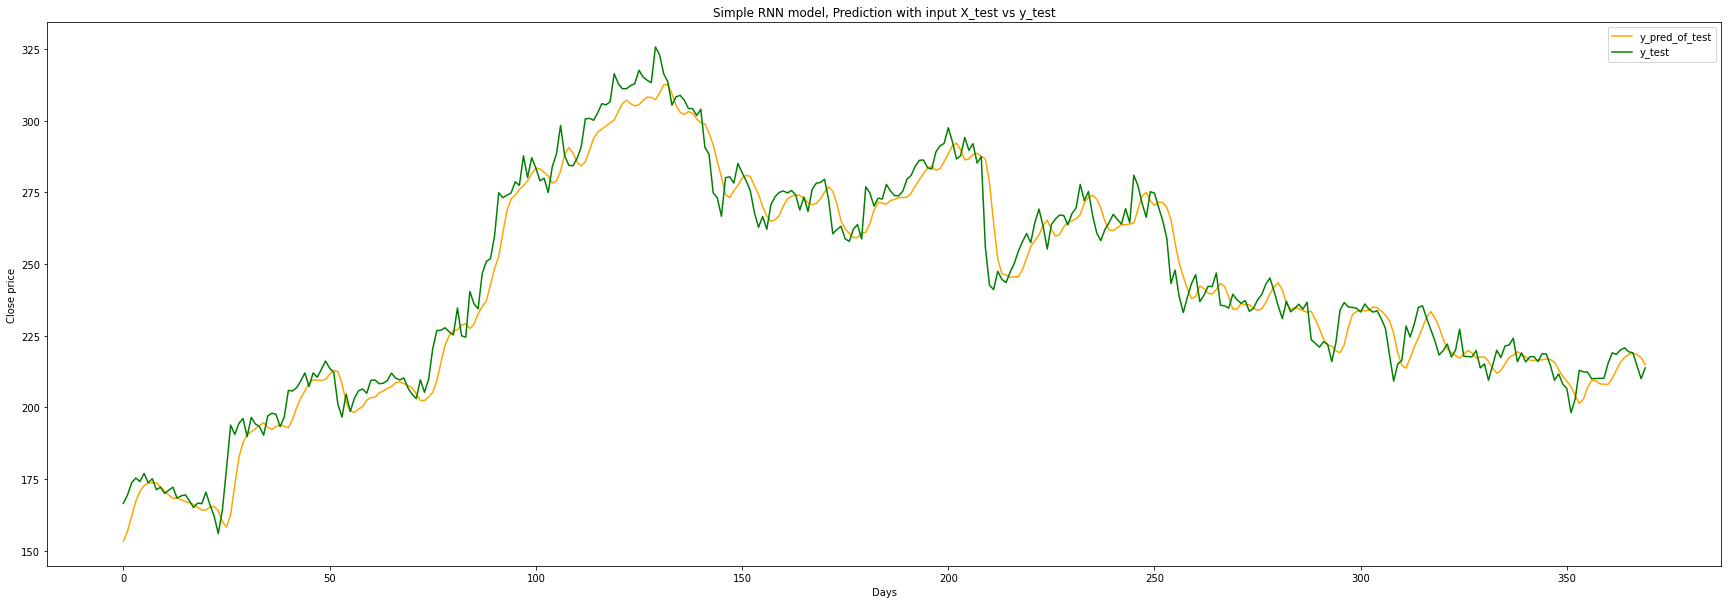

In [172]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

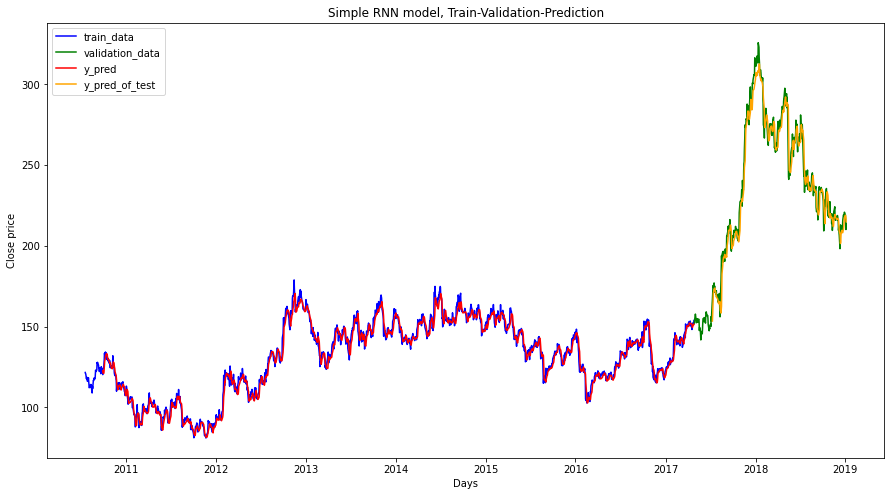

In [173]:
# Visualisation
plt.subplots(figsize =(15,8))
plt.plot(train_data.Date, train_data.Close, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Close, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()